In [ ]:
# !pip install fastai==2.8.2 --upgrade --quiet

# import os
# os.kill(os.getpid(), 9)

In [ ]:
import fastai
print(fastai.__version__)

2.7.19


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayodimeji","key":"21154b8d7a779264e1f6fd9060815a9a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip -q real-and-fake-face-detection.zip

Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
 94% 404M/431M [00:01<00:00, 263MB/s]
100% 431M/431M [00:01<00:00, 311MB/s]


In [ ]:
# !pip install -Uqq fastai

(#0) []

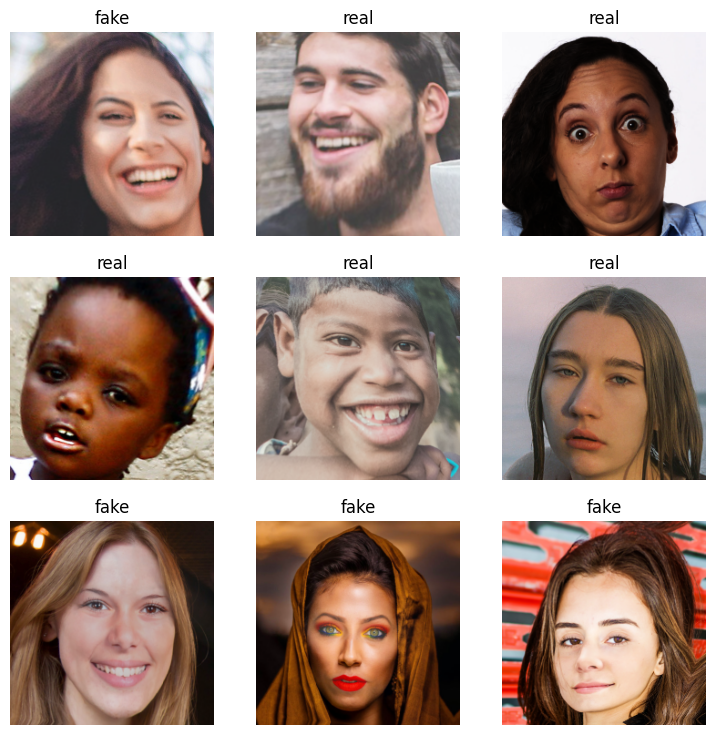

In [4]:
from pathlib import Path
from fastai.vision.all import *
from shutil import copyfile

src = Path('real_and_fake_face')
path = Path('real_and_fake_face_')
(path/"real").mkdir(parents=True, exist_ok=True)
(path/"fake").mkdir(parents=True, exist_ok=True)

for fname in (src/"training_real").iterdir():
  copyfile(fname, path/"real"/fname.name)
for fname in (src/"training_fake").iterdir():
  copyfile(fname, path/"fake"/fname.name)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=['real', 'fake'])),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(
        size=224,
        flip_vert=False,
        max_rotate=10,
        max_zoom=1.2,
        max_lighting=0.4,
        max_warp=0.3,
        p_affine=0.75,
        p_lighting=0.75,
      do_flip=True
    )
)
dls = dblock.dataloaders(path, bs=64)
dls.show_batch(max_n=9)
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

In [ ]:
# import shutil
# folder_path = '/content/real_and_fake_face_'
# shutil.rmtree(folder_path)

In [ ]:
dls.vocab, dls.c

(['fake', 'real'], 2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 178MB/s]


Find optimal learning rate


Fine-tuning with one-cycly policy


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.280018,0.861962,0.514706,0.560241,0.426606,0.484375,00:30


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.168556,0.848377,0.541667,0.600000,0.426606,0.498660,00:28
1,1.113516,0.792870,0.590686,0.642458,0.527523,0.579345,00:28
2,1.089089,0.847425,0.556373,0.641221,0.385321,0.481375,00:28
3,1.083489,0.801402,0.571078,0.635220,0.463303,0.535809,00:29
4,1.063936,0.792600,0.578431,0.643750,0.472477,0.544974,00:28


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

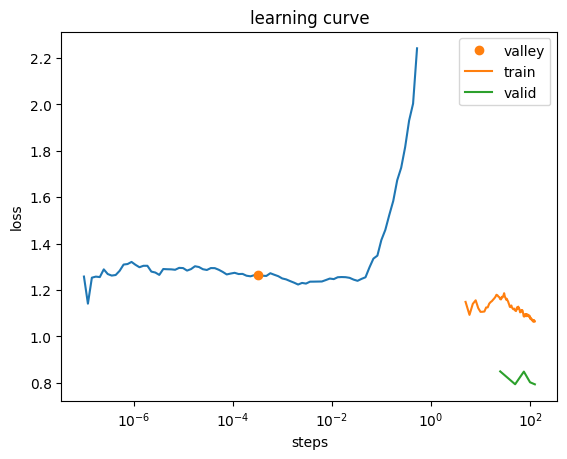

In [5]:
# Train the model
from fastai.vision.all import *
from fastai.callback.mixup import MixUp
from fastai.metrics import Precision, Recall, F1Score


learn = vision_learner(
    dls, resnet34, pretrained=True,
    metrics=[accuracy,Precision(), Recall(), F1Score()]
    )

learn.add_cb(MixUp()) # helps generalization

print("Find optimal learning rate")
learn.lr_find()

base_lr = 3e-4
print('Fine-tuning with one-cycly policy')

learn.fine_tune(5, base_lr=base_lr)
learn.recorder.plot_loss()

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(5, slice(1e-5, 1e-3))

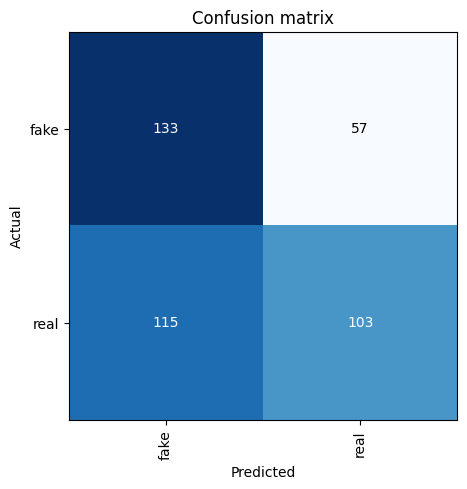

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


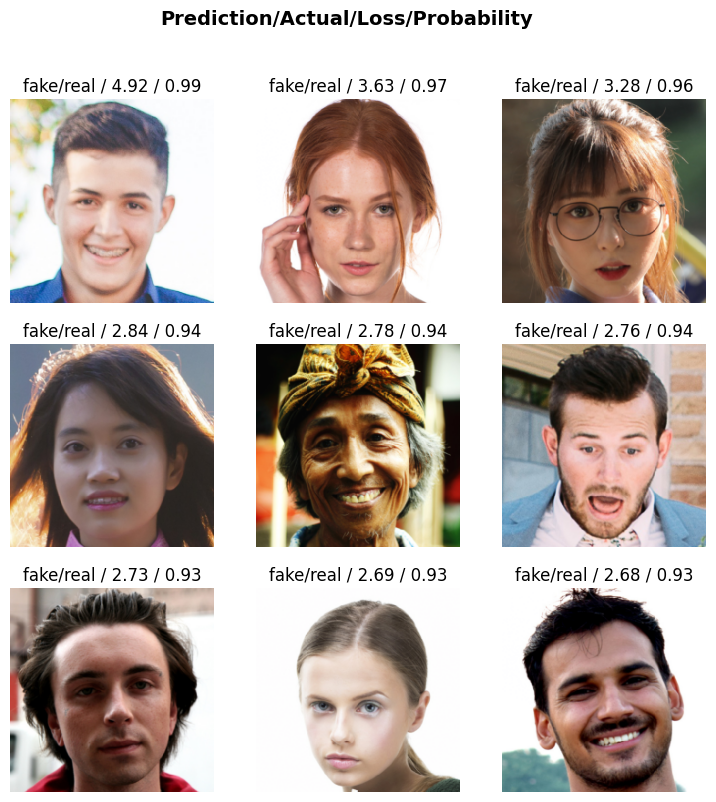

In [7]:
interp.plot_top_losses(9, nrows=3)

In [13]:
# Export the model for deployment
learn.export('real_vs_ai.pkl')

In [14]:
from google.colab import files
files.download('real_vs_ai.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import fastai
import torch
import torchvision
import numpy as np

print(f'fastai: {fastai.__version__}')
print(f'torch: {torch.__version__}')
print(f'torchvision: {torchvision.__version__}')
print(f'numpy: {np.__version__}')

fastai: 2.7.19
torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
numpy: 2.0.2


In [ ]:
# Delete all images selected for deletion
# for idx in cleaner.delete():
#   cleaner.fns[idx].unlink()

# To move images for which we've selected a different category
# for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Let's try the model on some data

In [ ]:
# im1 = Image.open('/content/Real?.19.51.png')
# im2 = Image.open('/content/Solomon.jpg')
# im3 = Image.open('/content/Sis Tomi.jpeg')
# image = [im1, im2, im3]
# for img in image:
#   img.thumbnail((192, 192))

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# axes = axes.flatten()

# for i, img in enumerate(image):
#   axes[i].imshow(img)
#   axes[i].axis('off')

# axes[3].axes("off")
# plt.tight_layout()
# plt.show()

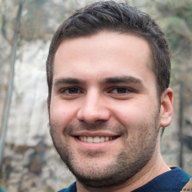

In [11]:
im1 = PILImage.create('/content/fake_face_1.jpg')
im1.thumbnail((192, 192))

im1

In [12]:
learn.predict(im1)

('fake', tensor(0), tensor([0.7003, 0.2997]))

In [8]:
from fastai.vision.all import *
# !pip install -Uqq fastai
# !pip install -Uqq fastbook
from fastbook import *
import matplotlib.pyplot as plt

# Folder to save images
path = Path('fake_faces')
path.mkdir(exist_ok=True)

# Download and predict on 5 fake faces
num_faces = 5
results = []

for i in range(num_faces):
    dest = path/f'fake_face_{i}.jpg'
    download_url('https://thispersondoesnotexist.com/', dest, show_progress=False,)

    img = PILImage.create(dest)
    pred, _, probs = learn.predict(img)

    results.append((img, pred, probs.max().item()))  # save image + prediction + confidence

# Visualize the predictions
for idx, (img, pred, conf) in enumerate(results):
    print(f"\nImage {idx+1}: Predicted: {pred}, Confidence: {conf:.2f}")
    display(img.to_thumb(200, 200))


ModuleNotFoundError: No module named 'fastbook'

In [ ]:
learn.loss_func = None
learn.metrics = []
learn.cbs = []

learn.export('real_vs_ai_clean.pkl', pickle_protocol=4)

In [ ]:
# learn.__dict__

In [ ]:
from google.colab import files
files.download('real_vs_ai_clean.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!python --version